In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
# Define global constants
kB = 1.380649 * 10**-23    # Boltzmann
h = 6.62607 * 10**-34      # Planck
R = 1.9858775 * 10**-3     # universal gas

def arrhenius(T, size=None):
    '''
    Draw values from exponential distribution at appropriate temperature and scale by prefactor
    '''
    
    beta = R*T
    sample = np.random.exponential(scale=beta, size=size)
    
    pre_factor = beta * kB*T/h
    
    return pre_factor*sample


def permeability_many_barriers(lam, ksm, kms, km):
    '''
    Calculate permeability from Eyring model expanded for many membrane barriers
    '''
    
    lam = lam * 10**-8 # cm
    
    num = lam*ksm
    den = 2 + kms*np.sum(1 / km)
    
    return num / den


def permeability_single_barrier(lam, delta, ksm, kms, km):
    '''
    Calculate permeability from Eyring model with single membrane barrier
    '''
    
    m = round(delta / lam)
    lam = lam * 10**-8 # cm
    
    num = lam*ksm*km
    den = 2*km + m*kms
    
    return num / den


def permeability_diffusion_dominant(lam, delta, ksm, kms, km):
    '''
    Calculate the permeability from Eyring model, assuming only diffusion contributes (i.e. P = K*D / delta)
    '''
    
    m = round(delta / lam)
    lam = lam * 10**-8 # cm
    
    num = lam*ksm*km
    den = m*kms
    
    return num / den


def permeability_partition_dominant(lam, delta, ksm, kms, km):
    '''
    Calculate the permeability from Eyring model, assuming only solution-membrane diffusion contributes (i.e. P = Dsm / 2*lam)
    '''
    
    lam = lam * 10**-8 # cm
    
    num = lam*ksm
    den = 2
    
    return num / den


def get_enthalpy_entropy(P, T, lam, delta):
    '''
    Linear regression to get slope and intercept from permeability and temperature, convert to enthalpy and entropy
    '''
    
    lam = lam * 10**-8 # cm
    
    logP = np.log(P*h/kB/T)
    invT = 1/T
    
    result = linregress(invT, logP)
    m = result.slope
    b = result.intercept
    
    dH = -m*R
    dS = (b - np.log(lam**2 / delta)) / R
    
    return dH, dS

In [3]:
# Set temperature range
temp = np.array([250, 275, 300, 325, 350])

# Input membrane thickness and jump length
delta = 200 # thickness (Angstroms)
lam = 2 # jump length (Angstroms)

# Allocate arrays for permeability
p_many = np.zeros(temp.shape[0])
p_average = np.zeros(temp.shape[0])
p_diffusion = np.zeros(temp.shape[0])
p_maximum = np.zeros(temp.shape[0])
p_minimum = np.zeros(temp.shape[0])

Temperature: 250 K
	P for normal distribution of barriers: 		986.27
	P for single, average barrier: 			986.27
	P for diffusion-dominant, average barrier: 	986.27
	P for single, largest barrier: 			986.27
	P for single, smallest barrier: 		986.27
Temperature: 275 K
	P for normal distribution of barriers: 		1.11
	P for single, average barrier: 			1.11
	P for diffusion-dominant, average barrier: 	1.11
	P for single, largest barrier: 			1.11
	P for single, smallest barrier: 		1.11
Temperature: 300 K
	P for normal distribution of barriers: 		103.99
	P for single, average barrier: 			103.99
	P for diffusion-dominant, average barrier: 	103.99
	P for single, largest barrier: 			103.99
	P for single, smallest barrier: 		103.99
Temperature: 325 K
	P for normal distribution of barriers: 		57.81
	P for single, average barrier: 			57.81
	P for diffusion-dominant, average barrier: 	57.81
	P for single, largest barrier: 			57.81
	P for single, smallest barrier: 		57.81
Temperature: 350 K
	P for norma

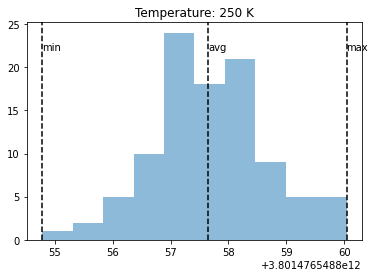

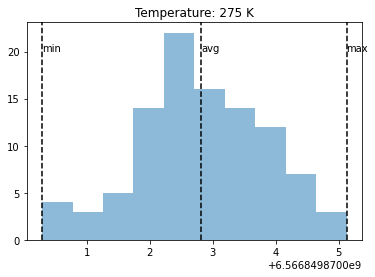

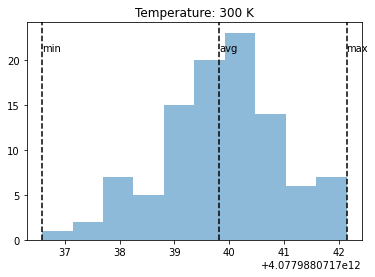

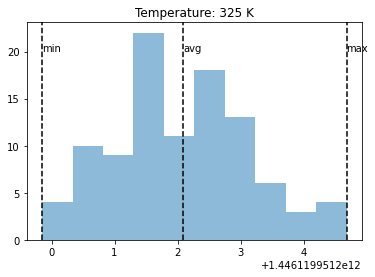

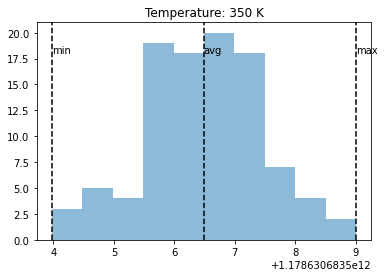

In [21]:
# Calculate rate constants for membrane transport, assuming membrane has many unequal barriers
for i,T in enumerate(temp):
    
    print('Temperature: {:.0f} K'.format(T))

    ksm = arrhenius(T)
    kms = arrhenius(T)
    km = arrhenius(T)
    
    n_jumps = int(delta / lam)
    km_array = np.random.normal(loc=km, scale=1.0, size=n_jumps)

    avg_km = km_array.mean() # average the individual membrane rate constants
    max_km = km_array.max()  # max of the individual membrane rate constants
    min_km = km_array.min()  # min of the individual membrane rate constant
    
    fig = plt.figure()
    n, _, _ = plt.hist(km_array, alpha=0.5)
    plt.axvline(avg_km, ls='dashed', c='k')
    plt.text(avg_km, n.max()-2, 'avg')
    plt.axvline(max_km, ls='dashed', c='k')
    plt.text(max_km, n.max()-2, 'max')
    plt.axvline(min_km, ls='dashed', c='k')
    plt.text(min_km, n.max()-2, 'min')
    plt.title('Temperature: {:.0f} K'.format(T))
    
    # Calculate permeability for membrane transport, assuming membrane has many unequal barriers
    P = permeability_many_barriers(lam, ksm, kms, km_array)
    p_many[i] = P
    print('\tP for normal distribution of barriers: \t\t{:,.2f}'.format(P))

    P_avg = permeability_single_barrier(lam, delta, ksm, kms, avg_km)
    p_average[i] = P_avg
    print('\tP for single, average barrier: \t\t\t{:,.2f}'.format(P_avg))
    
    P_diff = permeability_single_barrier(lam, delta, ksm, kms, avg_km)
    p_diffusion[i] = P_diff
    print('\tP for diffusion-dominant, average barrier: \t{:,.2f}'.format(P_diff))
    
    P_max = permeability_single_barrier(lam, delta, ksm, kms, max_km)
    p_maximum[i] = P_max
    print('\tP for single, largest barrier: \t\t\t{:,.2f}'.format(P_max))
    
    P_min = permeability_single_barrier(lam, delta, ksm, kms, min_km)
    p_minimum[i] = P_min
    print('\tP for single, smallest barrier: \t\t{:,.2f}'.format(P_min))

In [8]:
# Calculate the enthalpic and entropic barriers
dH_many, dS_many = get_enthalpy_entropy(p_many, temp, lam, delta)
dH_avg, dS_avg = get_enthalpy_entropy(p_average, temp, lam, delta)
dH_diff, dS_diff = get_enthalpy_entropy(p_diffusion, temp, lam, delta)
dH_max, dS_max = get_enthalpy_entropy(p_maximum, temp, lam, delta)
dH_min, dS_min = get_enthalpy_entropy(p_minimum, temp, lam, delta)

print('Many barriers:')
print('\tEnthalpy = {:,.2f}'.format(dH_many))
print('\tEntropy = {:,.2f}'.format(dS_many))

print('Single, average barrier:')
print('\tEnthalpy = {:,.2f}'.format(dH_avg))
print('\tEntropy = {:,.2f}'.format(dS_avg))

print('Diffusion-dominant, average barrier:')
print('\tEnthalpy = {:,.2f}'.format(dH_diff))
print('\tEntropy = {:,.2f}'.format(dS_diff))

print('Single, largest barrier:')
print('\tEnthalpy = {:,.2f}'.format(dH_max))
print('\tEntropy = {:,.2f}'.format(dS_max))

print('Single, smallest barrier:')
print('\tEnthalpy = {:,.2f}'.format(dH_min))
print('\tEntropy = {:,.2f}'.format(dS_min))

Many barriers:
	Enthalpy = 7.50
	Entropy = 13,703.00
Single, average barrier:
	Enthalpy = 2.81
	Entropy = 11,055.92
Diffusion-dominant, average barrier:
	Enthalpy = 2.81
	Entropy = 11,055.92
Single, largest barrier:
	Enthalpy = 2.62
	Entropy = 11,595.90
Single, smallest barrier:
	Enthalpy = 7.64
	Entropy = 11,946.44
